In [94]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [7]:
# Constant
IMG_SIZE = 256
BATCH_SIZE = 32 # per batch will contain 32 images
CHANNELS = 3
EPOCHS = 50

In [8]:
# Load Dataset 
dataset = tf.keras.preprocessing.image_dataset_from_directory(directory="dataset",
                                                             shuffle = True,
                                                             image_size = (IMG_SIZE,IMG_SIZE),
                                                             batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names # [0,1,2]

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset) # Total batch

68

In [11]:
68 * 32

2176

In [12]:
for image_batch, label_batch in dataset.take(1): # Taking 1 batch that contain 32 images
    print(image_batch.shape)
    print(label_batch)

(32, 256, 256, 3)
tf.Tensor([1 1 1 2 0 0 2 1 2 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1], shape=(32,), dtype=int32)


(256, 256, 3)


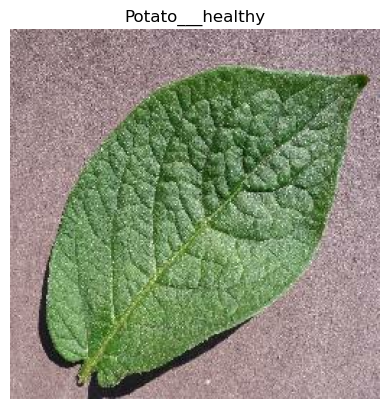

In [13]:
for image_batch, label_batch in dataset.take(1): # Taking 1 batch that contain 32 images
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")
    print(image_batch[0].shape) # First images

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


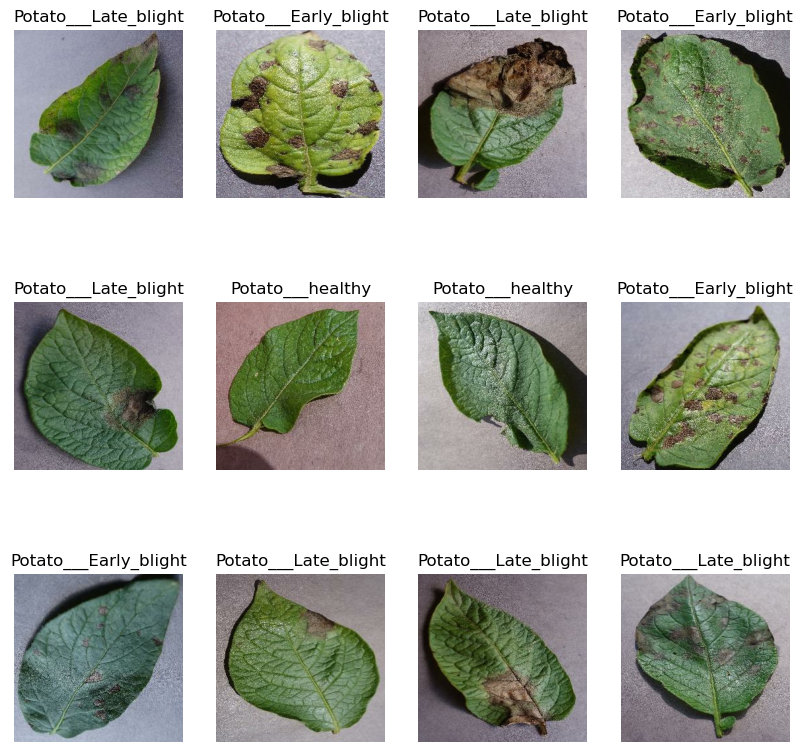

In [14]:
# Show 12 images
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1): # Taking 1 batch that contain 32 images
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        print(image_batch[i].shape)

In [15]:
# 80% training, 10% validation, 10% test (manual process)

# train_ds = dataset.take(int(len(dataset)*0.8)) # 80%
# temp_ds = dataset.skip(len(train_ds)) # 20%

# test_ds = temp_ds.take(int(len(temp_ds)*0.5)) # 50% of 20% => 10%
# validation_ds = temp_ds.skip(len(test_ds)) # 50% of 20% -> 10%

# len(train_ds), len(test_ds), len(validation_ds)

In [16]:
# Make function for spliting
def get_dataset_split(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=32)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds
    
    

In [17]:
train_ds, test_ds, val_ds = get_dataset_split(dataset)

In [18]:
len(train_ds), len(test_ds), len(val_ds)

(54, 8, 6)

In [19]:
# Improve training performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
# Resize and Rescale
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1.0 / 255)
])

In [21]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [22]:
# Model
input_shape = (BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)
num_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes,activation="softmax")
])

model.build(input_shape = input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [24]:
model.compile(optimizer = 'adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [25]:
history = model.fit(train_ds,
                     epochs=EPOCHS,
                     batch_size = BATCH_SIZE,
                     verbose=1,
                     validation_data = val_ds)

Epoch 1/50
54/54 [==============================] - 20s 221ms/step - loss: 0.8819 - accuracy: 0.5340 - val_loss: 0.8069 - val_accuracy: 0.6302
Epoch 2/50
54/54 [==============================] - 8s 150ms/step - loss: 0.6199 - accuracy: 0.7330 - val_loss: 0.5636 - val_accuracy: 0.7604
Epoch 3/50
54/54 [==============================] - 8s 145ms/step - loss: 0.3863 - accuracy: 0.8322 - val_loss: 0.2496 - val_accuracy: 0.9115
Epoch 4/50
54/54 [==============================] - 8s 145ms/step - loss: 0.2779 - accuracy: 0.8944 - val_loss: 0.2744 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 8s 146ms/step - loss: 0.2501 - accuracy: 0.9026 - val_loss: 0.1805 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 8s 145ms/step - loss: 0.2024 - accuracy: 0.9196 - val_loss: 0.1600 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 8s 144ms/step - loss: 0.1975 - accuracy: 0.9155 - val_loss: 0.1326 - val_accuracy: 0.9375
Epoch

In [26]:
scodes = model.evaluate(test_ds)

8/8 [==============================] - 3s 60ms/step - loss: 0.0355 - accuracy: 0.9883


In [27]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

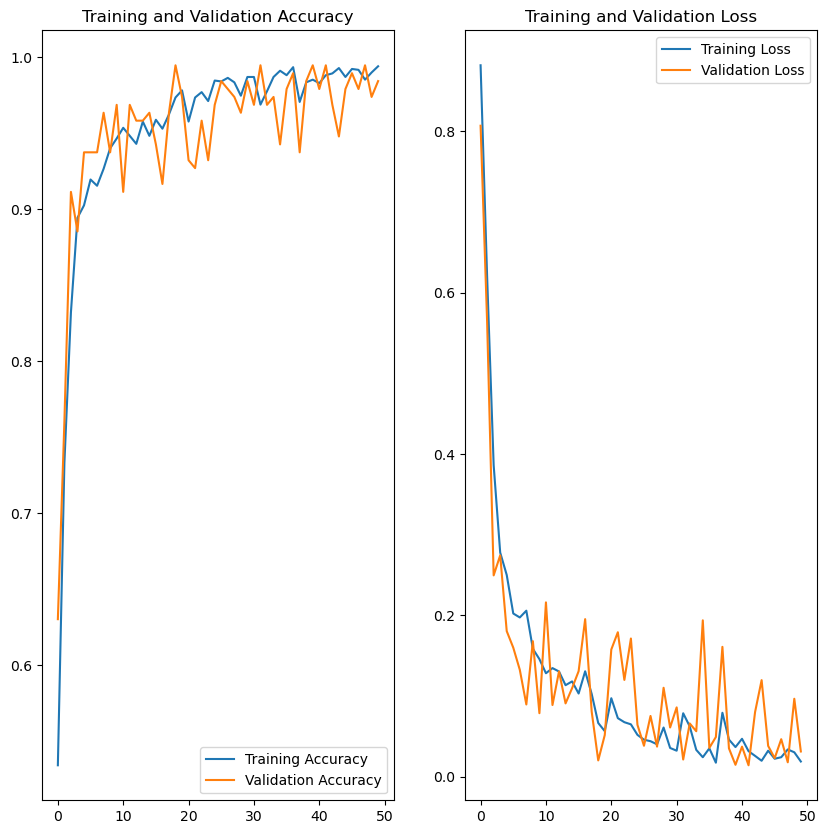

In [37]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

### Prediction

First Image Prediction
Actual label : Potato___healthy
Predicted Label : Potato___healthy
Confidence : 99.99%


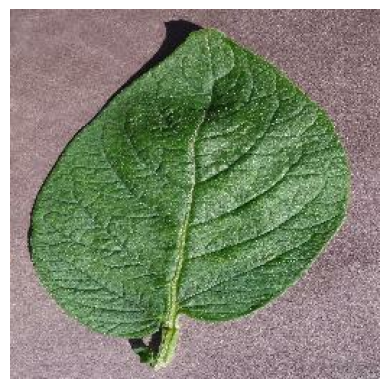

In [59]:
# Prediction manually
import numpy as np

for image_batch, labels_batch in test_ds.take(1): # taking 1 batch (32 images)
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First Image Prediction")
    plt.imshow(first_image)
    plt.axis(False)
    print(f"Actual label : {class_names[first_label]}")
    
    batch_prediction = model.predict(image_batch) # whole batch prediction (32 images)
    print(f"Predicted Label : {class_names[np.argmax(batch_prediction[0])]}")
    confidence = round(100 * (np.max(batch_prediction[0])),2)
    print(f"Confidence : {confidence}%")

In [91]:
# prediction using function

def prediction(num=6,model=model):
    plt.figure(figsize=(15,15))
    for image_batch, labels_batch in test_ds.take(1): # taking 1 batch (32 images)
        for i in range(num):
                img = image_batch[i].numpy().astype('uint8')
                label = labels_batch[i].numpy()

                ax = plt.subplot(3,3,i+1)
                plt.imshow(img)
                actual_label = class_names[label]

                batch_prediction = model.predict(image_batch) # whole batch prediction (32 images)
                predicted_label = class_names[np.argmax(batch_prediction[i])]
                confidence = round(100 * (np.max(batch_prediction[i])),2)
                
                plt.title(f"Actual Label : {actual_label} \n Predicted Label : {predicted_label} \n Confidence : {confidence}%")
                plt.axis("off")

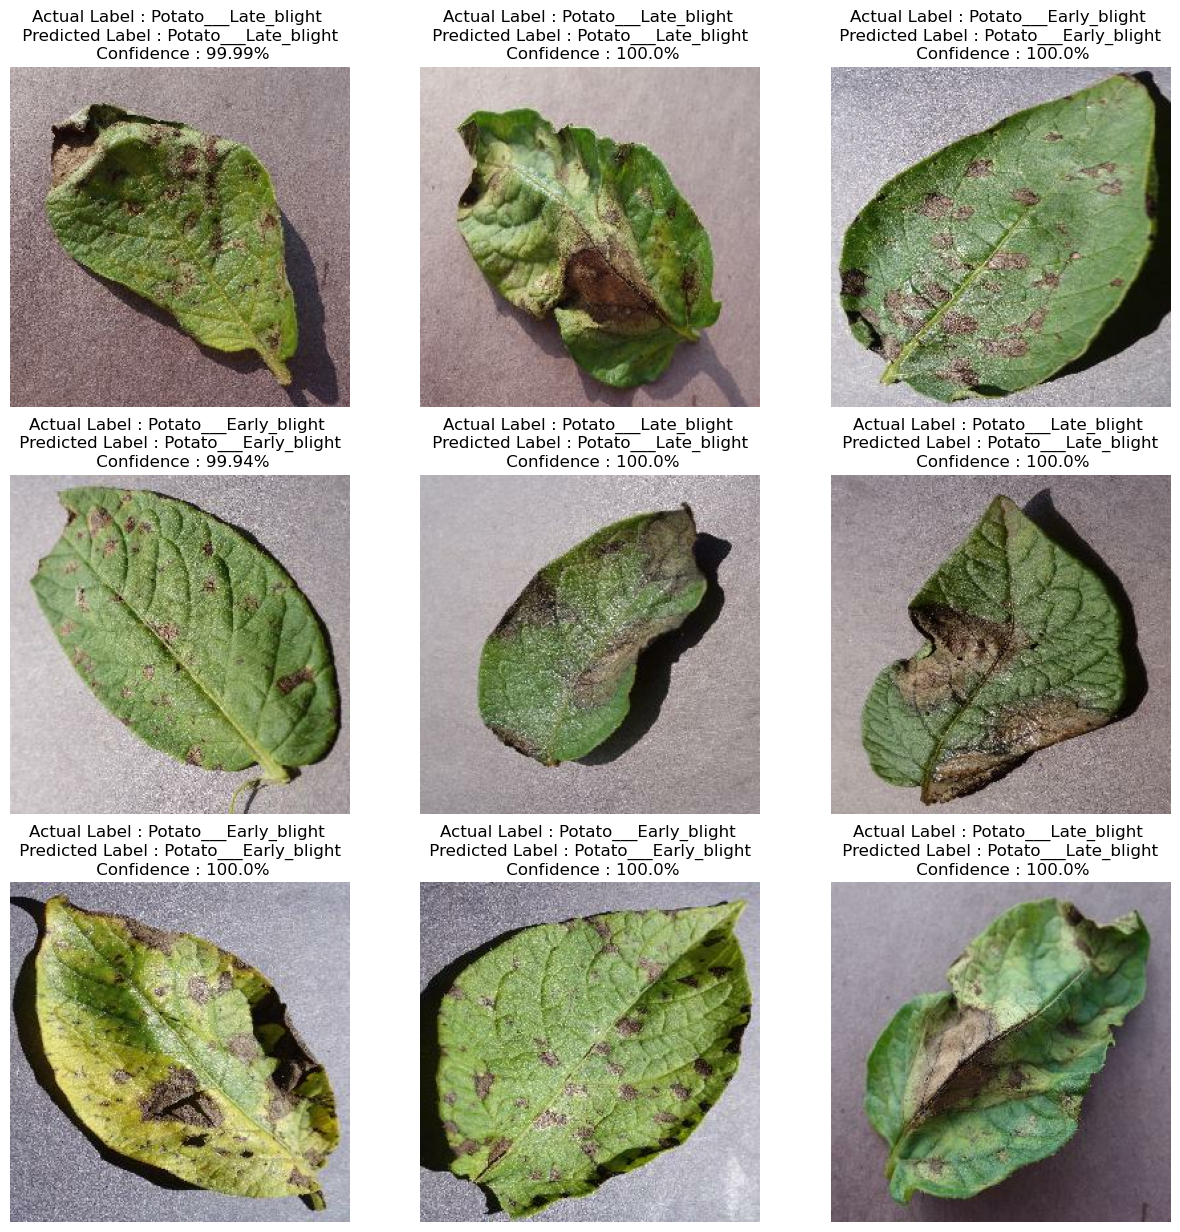

In [92]:
prediction(9)

### Model Save

In [88]:
model_version = "v1"
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/v1\assets


### Load Model

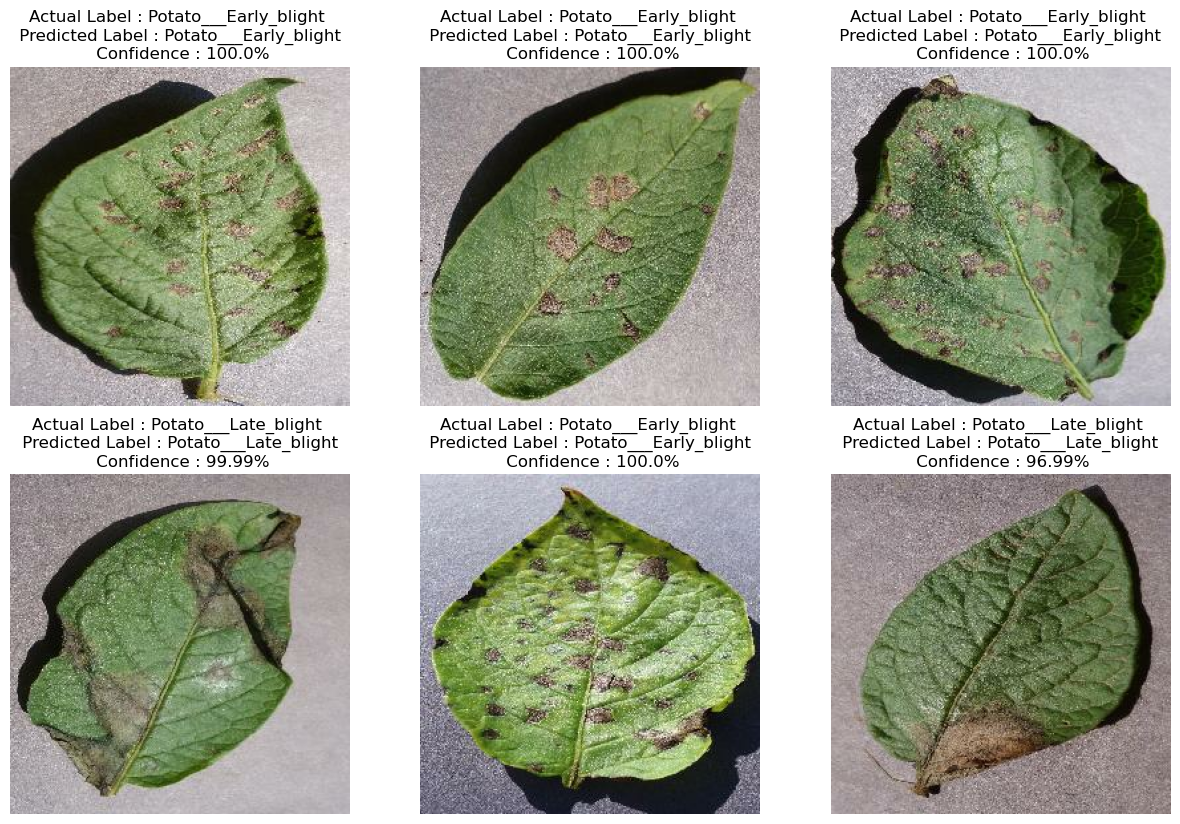

In [98]:
loaded_model = load_model(f"models/{model_version}")
prediction(num = 6,model=loaded_model)